We will use the data frame obtained in the previous step to work with unstructured data (reviews) and structured data

##Install required libraries

In [ ]:
pip install pyLDAvis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import gensim
import spacy
import re
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

import pickle
import pyLDAvis
import pyLDAvis.gensim

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [11]:
df = pd.read_csv('/content/british_airways_reviews.csv')
df.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Index(['Date', 'Overall Rating', 'Country', 'Impression', 'Verification',
       'Review', 'Type Of Traveller', 'Seat Type', 'Route', 'Date Flown',
       'Seat Comfort', 'Cabin Staff Service', 'Ground Service',
       'Value For Money', 'Recommended', 'Aircraft', 'Food & Beverages',
       'Inflight Entertainment', 'Wifi & Connectivity'],
      dtype='object')

Natural Language Toolkit (NLTK) library is one of the most widely used libraries for natural language processing in Python.

In [ ]:
nltk.download('all') #Includes pre-trained models, corpora, and other resources that NLTK uses to perform various NLP tasks.

## Data Visualization

First, the data is analyzed to count how many entries exist for each country, and this count is organized in a new format. The ten countries with the highest counts are identified and listed. Then, the average overall rating for each country is calculated by grouping the data by country and determining the mean of the "Overall Rating" entries. A summary is created by merging the country counts with the average ratings. Finally, a bar chart is generated to visually represent the average overall ratings for the top ten countries, with the count of entries displayed on the bars.

In [5]:
country_counts = df['Country'].value_counts().reset_index()
top_countries = country_counts.nlargest(11, 'count')['Country']
country_rating = df.groupby('Country')['Overall Rating'].mean().reset_index()
country_summary = country_counts.merge(country_rating, on='Country').query('Country in @top_countries')
country_summary = country_summary[country_summary['Country'].isin(top_countries)]
fig = px.bar(country_summary, x='Country', y='Overall Rating', text='count', title='Average Overall Ratings for Top 11 Countries',
             labels={'Overall Rating': 'Average Overall Rating', 'Country': 'Country'},
             color='Overall Rating', color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Analyze how ratings and sentiments change over time (using the "Date"
column). This can show whether recent changes have had a positive or negative impact on customer satisfaction.

In [6]:
# Створення об'єкта subplot з 1 рядком і 2 колонками
fig = make_subplots(rows=1, cols=2, subplot_titles=("Average Overall Rating Through Years (Starting from 2019)", "Distribution of recommendations over the years"))

# Перший графік
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
avg_rating_per_year = (df[df['Year'] >= 2019].groupby('Year')['Overall Rating'].mean().reset_index())

fig1 = px.line(avg_rating_per_year, x='Year', y='Overall Rating', markers=True, labels={'Overall Rating': 'Average Rating'})
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)

# Create a histogram with a hue over the 'Recommended' column
fig2 = px.histogram(df, x='Year', color='Recommended', nbins=11)
fig2.update_layout(barmode='group')  # Place bars side by side
for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)

# Додаткові налаштування
fig.update_layout(title_text="Trend Analysis Over Time")
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Determine if there's a correlation between "Overall Rating" and other numerical ratings such as "Seat Comfort", "Cabin Staff Service", "Ground Service", "Value For Money", "Food & Beverages", and "Inflight Entertainment". This can highlight which factors most strongly influence overall satisfaction.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



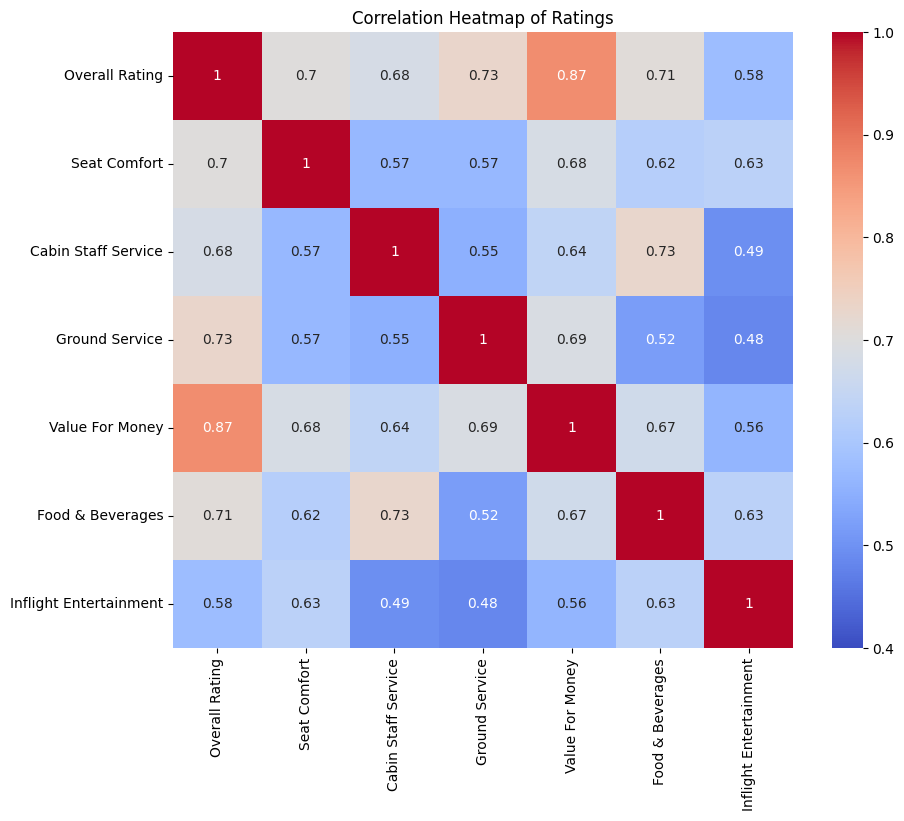

In [7]:
# Selecting only relevant numerical columns
columns_of_interest = [
    "Overall Rating",
    "Seat Comfort",
    "Cabin Staff Service",
    "Ground Service",
    "Value For Money",
    "Food & Beverages",
    "Inflight Entertainment"
]

# Drop rows with missing values in the selected columns
df = df[columns_of_interest].dropna()

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=0.4, vmax=1)
plt.title("Correlation Heatmap of Ratings")
plt.show()

# Topic Modeling

## Preprocessing Text
Text preprocessing is a crucial step in performing sentiment analysis, as it helps to clean and normalize the text data, making it easier to analyze.
1. Case folding: Convert all text to lowercase.
2. Tokenization with NLTK: The ```word_tokenize``` function is used to split the text into individual tokens.
3. Stop-word removal: Remove commonly used words that don’t carry significant meaning.
4. Punctuation removal: Strip punctuation marks.
5. Lemmatization: a process that aims to normalize text/words based on the basic form which is the lemma form. The distinction between stemming and lemmatization is while stemming changes a word into a root word without knowing the context of the word like cutting off the ends of words, lemmatization changes a word into a root word by knowing the context of the word              


In [ ]:
# Add 'ba' and other words to the stop words list (this words seem to be general to affect the topic)
stop_words = set(stopwords.words('english'))
stop_words.update(['ba', 'flight', 'british', 'airways'])
nlp = spacy.load('en_core_web_sm')
def preproces_text(text, nlp):
  # Convert text to lowercase
  text = text.lower()
  # Tokenize the text
  tokens = word_tokenize(text)
  # Remove stop words
  tokens = [word for word in tokens if word not in stop_words]
  # Join the tokens back into a single string for punctuation removal
  filtered_text = ' '.join(tokens)
  # Remove punctuation using regular expressions
  filtered_text = re.sub(r'[^\w\s]', '', filtered_text)
  # Process the cleaned text with spaCy
  doc = nlp(filtered_text)
  # Lemmatize the tokens and remove any remaining stop words (if needed)
  lemmatized_tokens = [token.lemma_ for token in doc if token.lemma_.strip()]
  # Return the lemmatized tokens
  return lemmatized_tokens

## POS Tagging
Part of speech tagging. Part-of-speech (POS) tagging or in short it can be written as tagging is the process of assigning POS tags or syntactic classes to each word in the corpus (Gimpel et al., 2011).
Part of speech has an important role to form a sentence so that it is coherent and follows the grammar of the sentence.

I used  POS Tagging to extract nouns from each user review in the text corpus since they usually have the main semantic load.                                                             

In [ ]:
def extract_nouns(lemmatized_tokens, nlp):
    # Join the lemmatized tokens back into a string for spaCy to process
    processed_text = ' '.join(lemmatized_tokens)

    # Process the text with spaCy to extract nouns
    doc = nlp(processed_text)

    # Extract nouns based on POS tags and join them into a string
    nouns = ([token.text for token in doc if token.pos_ == 'NOUN'])

    # Return the string of nouns
    return nouns

In [ ]:
text_data = df[['Review', 'Impression']]
lemmatized_review = text_data['Review'].apply(lambda x:
                                                      preproces_text(x, nlp))

text_data['Cleaned Impression'] = text_data['Impression'].apply(lambda x: preproces_text (x, nlp))
text_data['Cleaned Review'] = lemmatized_review.apply(lambda x: extract_nouns(x, nlp))

In [13]:
text_data[['Review', 'Cleaned Review', 'Cleaned Impression']].head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Review,Cleaned Review,Cleaned Impression
0,I recently travelled from Munich to London ...,"[nightmare, trouble, malfunction, app, check, ...","[never, fly]"
1,I paid for seats 80 A and B on my flight fro...,"[seat, b, heathrow, boston, pay, premium, econ...","[still, hear, update]"
2,"The flight wasn’t that bad, although the Infl...","[entertainment, screen, oldfashione, touch, sc...","[cabin, crew, nice]"
3,I decided to treat myself and my teenage dau...,"[daughter, holiday, pound, end, hour, trap, se...","[support, staff, wash, hand]"
4,I was very impressed with their efficient bo...,"[boarding, air, seat, quality, food, drink, sn...","[fuss, bother, experience]"


## Sentiment Analyzer
*We will use the impression column, which summarizes the main idea of ​​the feedback, to evaluate its mood*

First, we’ll initialize a Sentiment Intensity Analyzer object from the ```nltk.sentiment.vader``` library.

Next, we’ll call the polarity_scores method of the analyzer object to obtain a dictionary of sentiment scores for the text, which includes a score for positive, negative, and neutral sentiment.

The 'compound' score, which ranges from -1 (most negative) to 1 (most positive), is used.

This creates a new column called Sentiment Score in the DataFrame, which stores the sentiment score for each review.


In [14]:
# Sentiment Analysis
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to the cleaned text
text_data['Sentiment Score'] = text_data['Cleaned Impression'].apply(lambda x: sia.polarity_scores(' '.join(x))['compound'])

# Add a sentiment label based on the compound score
text_data['Sentiment Label'] = text_data['Sentiment Score'].apply(
    lambda score: 'Positive' if score > 0 else ('Negative' if score < 0 else 'Neutral'))

# Display the results

pd.DataFrame(text_data).head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-14-8d1643433e28>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-8d1643433e28>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Review,Impression,Cleaned Impression,Cleaned Review,Sentiment Score,Sentiment Label
0,I recently travelled from Munich to London ...,"""never fly with them again""","[never, fly]","[nightmare, trouble, malfunction, app, check, ...",0.0000,Neutral
1,I paid for seats 80 A and B on my flight fro...,"""still have not heard any updates""","[still, hear, update]","[seat, b, heathrow, boston, pay, premium, econ...",0.0000,Neutral
2,"The flight wasn’t that bad, although the Infl...","""cabin crew were nice""","[cabin, crew, nice]","[entertainment, screen, oldfashione, touch, sc...",0.4215,Positive
3,I decided to treat myself and my teenage dau...,"""support staff wash their hands of you""","[support, staff, wash, hand]","[daughter, holiday, pound, end, hour, trap, se...",0.7096,Positive
4,I was very impressed with their efficient bo...,"""no fuss, no bother experience""","[fuss, bother, experience]","[boarding, air, seat, quality, food, drink, sn...",-0.3400,Negative
5,The flight scheduled at 1840 left 2hours 40 ...,"""Who can trust BA to travel2","[trust, travel2]","[schedule, minute, alter, arrival, aircraft, n...",0.5106,Positive
6,I have been flying BA for over 15 years. I ...,"""just another poor airline""","[another, poor, airline]","[year, gold, member, year, thing, notice, year...",-0.4767,Negative
7,On arriving at Mexico Airport we were told ...,"""spent two hours trying to make contact with BA""","[spend, two, hour, try, make, contact]","[delay, aircraft, replacement, aircraft, lhr, ...",0.0000,Neutral
8,I have flown British Airways for many years...,"""using another airline for future travel""","[use, another, airline, future, travel]","[year, flight, summer, minute, connect, airpor...",0.0000,Neutral
9,"We bought tickets for a Geneva-London flight,...","""oversold tickets on our flight""","[oversell, ticket]","[ticket, genevalondon, airport, airline, ticke...",-0.2263,Negative


In [15]:
# Підрахунок кількості кожної категорії (Positive, Negative, Neutral)
sentiment_counts = text_data['Sentiment Label'].value_counts()

# Створення кругової діаграми
fig = px.pie(values=sentiment_counts, names=sentiment_counts.index,
             title="Distribution of Sentiment Labels",
             color_discrete_sequence=px.colors.qualitative.Pastel)

fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Before we can use this data as input to a LDA or LSA model, it must be converted to a term-document matrix. A term-document matrix is merely a mathematical representation of a set of documents and the terms contained within them.

It’s created by counting the occurrence of every term in each document and then normalizing the counts to create a matrix of values that can be used for analysis.

In [ ]:
dictionary = corpora.Dictionary(text_data['Cleaned Review'])
corpus = [dictionary.doc2bow(review) for review in text_data['Cleaned Review']] #'dictionary.doc2bow(doc)' is used to convert each document into the bag-of-words (BoW) format.
                                                                              #The BoW format represents each document as a list of tuples, where each tuple contains a unique word's ID and its frequency in the document.


## Modeling

The first model we’ll use in LSA:

In [ ]:
from gensim.models import LsiModel
# LSA model
lsa = LsiModel(corpus, num_topics=6, id2word = dictionary) #doc_term_matrix is a matrix representation of the document,
                                                          # num_topics is the number of topics to extract,
                                                          # and id2word is a mapping from word IDs to words.

# LSA model
for idx, topic in lsa.print_topics(num_topics=6, num_words=5):
    print(f"Topic {idx}: {topic}")

This outputs the topics (each line) with individual topic terms (terms) and their weights.

Let’s try it with LDA:

In [18]:
from gensim.models import LdaModel

# LDA model
lda = LdaModel(corpus, num_topics=6, id2word = dictionary, passes=10,random_state=45)

# Results
for idx, topic in lda.print_topics(num_topics=6, num_words=5):
    print(f"Topic {idx}: {topic}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic 0: 0.041*"seat" + 0.028*"class" + 0.026*"food" + 0.026*"cabin" + 0.025*"business"
Topic 1: 0.034*"time" + 0.020*"crew" + 0.016*"cabin" + 0.016*"passenger" + 0.014*"lounge"
Topic 2: 0.023*"time" + 0.022*"day" + 0.022*"hour" + 0.018*"service" + 0.018*"luggage"
Topic 3: 0.026*"hour" + 0.025*"customer" + 0.023*"service" + 0.017*"book" + 0.016*"call"
Topic 4: 0.027*"crew" + 0.023*"class" + 0.023*"seat" + 0.019*"service" + 0.019*"business"
Topic 5: 0.042*"seat" + 0.022*"service" + 0.020*"airline" + 0.015*"food" + 0.015*"time"


Let's focus on the LDA model, as it`s more suitable for our case

Topic modeling is useful, but it’s difficult to understand it just by looking at a combination of words and numbers like above.

One of the most effective ways to understand data is through visualization. Is there a way that we can visualize the results of LDA? Yes, we can with pyLDAvis.


In [19]:
# Prepare the LDA model for visualization
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary)

# Display the visualization
pyLDAvis.display(lda_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



A good topic model will have big and non-overlapping bubbles scattered throughout the chart. As we can see from the graph, some bubbles are clustered within one place. Can we do better than this?

Yes, our model will be better if the words in a topic are similar, so we will use topic coherence to evaluate our model. Topic coherence evaluates a single topic by measuring the degree of semantic similarity between high scoring words in the topic. A good model will generate topics with high topic coherence scores.

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=text_data['Cleaned Review'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('nCoherence Score: ', coherence_lda)

Let's check the coherence scores for different number of topics

In [21]:
# Function to train LDA model and calculate coherence score
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    topic_num = []

    for num_topics in range(start, limit, step):
        # Train the LDA model
        lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=45)
        topic_num.append(num_topics)

        # Compute the Coherence Score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())

        print(f'Num Topics = {topic_num[-1]}, Coherence Score = {coherence_model_lda.get_coherence()}')

    return topic_num , coherence_values

# Define the range for number of topics
start = 2   # Starting number of topics
limit = 10  # Maximum number of topics to test
step = 1    # Step size (increment in topics)

# Compute coherence values for different number of topics
topic_num , coherence_values = compute_coherence_values(dictionary, corpus, text_data['Cleaned Review'], start, limit, step)

# Print the coherence values for each number of topics
#for i, num_topics in enumerate(range(start, limit, step)):
#    print(f'Number of Topics: {num_topics}, Coherence Score: {coherence_values[i]}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Num Topics = 2, Coherence Score = 0.5154099703781405
Num Topics = 3, Coherence Score = 0.5232363955657323
Num Topics = 4, Coherence Score = 0.528080907152576
Num Topics = 5, Coherence Score = 0.5005299583566634
Num Topics = 6, Coherence Score = 0.5169225993411593
Num Topics = 7, Coherence Score = 0.5203053070265766
Num Topics = 8, Coherence Score = 0.5068580223795752
Num Topics = 9, Coherence Score = 0.4877649314762525


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



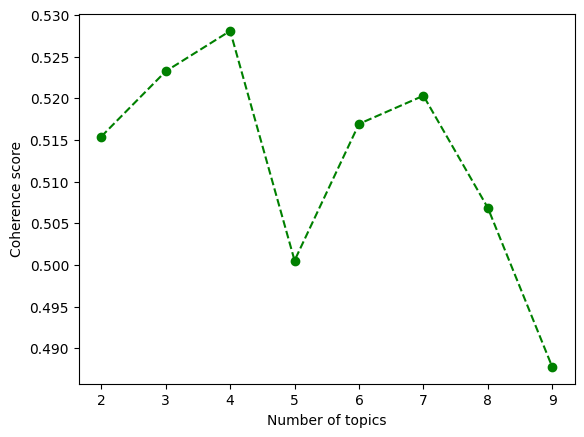

In [22]:
plt.plot(topic_num , coherence_values,color='green', marker='o', linestyle='dashed')
plt.xticks(range(2,10))
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.show()


Although the coherence score is hight for 5 topics, indicating more interpretable themes compared to four, the visual overlap suggests that there may be redundancy in the identified topics. The overlap indicates that some topics may not be sufficiently distinct to provide clear and unique insights, potentially leading to difficulties in interpreting the results.

Thus, while 5 topics achieved a good coherence score, the actual separability of the topics is compromised, suggesting a trade-off between coherence and distinctiveness.








In [23]:
# LDA model
lda_4 = LdaModel(corpus, num_topics=4, id2word = dictionary, passes=10, random_state=45)

# Results
for idx, topic in lda_4.print_topics(num_topics=4, num_words = 20):
    print(f"Topic {idx}: {topic}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic 0: 0.045*"seat" + 0.030*"class" + 0.027*"business" + 0.024*"food" + 0.022*"service" + 0.021*"cabin" + 0.019*"crew" + 0.016*"economy" + 0.015*"meal" + 0.013*"time" + 0.011*"passenger" + 0.011*"drink" + 0.010*"club" + 0.010*"boarding" + 0.009*"airline" + 0.008*"staff" + 0.008*"experience" + 0.008*"lounge" + 0.007*"hour" + 0.007*"aircraft"
Topic 1: 0.031*"time" + 0.026*"crew" + 0.020*"seat" + 0.019*"service" + 0.015*"cabin" + 0.014*"hour" + 0.013*"passenger" + 0.012*"food" + 0.012*"aircraft" + 0.011*"minute" + 0.010*"lounge" + 0.010*"flight" + 0.010*"delay" + 0.010*"departure" + 0.009*"airline" + 0.009*"club" + 0.008*"board" + 0.008*"heathrow" + 0.008*"drink" + 0.008*"boarding"
Topic 2: 0.023*"staff" + 0.022*"hour" + 0.020*"time" + 0.018*"service" + 0.017*"day" + 0.014*"customer" + 0.013*"luggage" + 0.010*"delay" + 0.010*"book" + 0.009*"phone" + 0.008*"airline" + 0.008*"plane" + 0.008*"passenger" + 0.008*"ticket" + 0.007*"airport" + 0.007*"experience" + 0.007*"travel" + 0.006*"way" 

In [24]:
# Prepare the LDA model for visualization
lda_4_display = pyLDAvis.gensim.prepare(lda_4, corpus, dictionary)

# Display the visualization
pyLDAvis.display(lda_4_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Using the capabilities of generative AI, we can determine the main problem

1. Topic 0: Booking and Travel Logistics

2. Topic 1: In-flight Experience and Cabin Comfort

3. Topic 2: Passenger Service and Baggage

4. Topic 3: Flight Delays and Ground Support


Next code is associating each topic number produced by LDA with a human-readable topic name. This is done by creating a ```topic_lookup_data ```DataFrame that maps ```Topic_Number``` to ```Topic_Name``` and ```Top_Keywords```.

In [25]:
topic_lookup_data = pd.DataFrame((lda_4.print_topics()),columns=['Topic_Number','Top_Keywords'])
topic_lookup_data['Topic_Name'] = ['Booking & Travel Logistics', 'In-flight Experience & Cabin Comfort', 'Passenger Service & Baggage',
'Flight Delays & Ground Support']
topic_lookup_data = topic_lookup_data[['Topic_Number','Topic_Name','Top_Keywords']]
topic_lookup_data['Top_Keywords'] = topic_lookup_data.Top_Keywords.str\
.replace(r'[^a-z]',' ',regex=True).apply(lambda x: x.split())
topic_lookup_data.style.set_properties(subset=['Top_Keywords'], **{'width': '300px'})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Topic_Number,Topic_Name,Top_Keywords
0,0,Booking & Travel Logistics,"['seat', 'class', 'business', 'food', 'service', 'cabin', 'crew', 'economy', 'meal', 'time']"
1,1,In-flight Experience & Cabin Comfort,"['time', 'crew', 'seat', 'service', 'cabin', 'hour', 'passenger', 'food', 'aircraft', 'minute']"
2,2,Passenger Service & Baggage,"['staff', 'hour', 'time', 'service', 'day', 'customer', 'luggage', 'delay', 'book', 'phone']"
3,3,Flight Delays & Ground Support,"['hour', 'customer', 'service', 'book', 'airline', 'day', 'seat', 'call', 'time', 'bag']"


Next code iterates over each document's topic distribution generated by the LDA model, extracts the top 1 or 2 topics with the highest relevance, and stores those topics (as a comma-separated string) in a DataFrame. It only adds a second topic if it contributes more than 35% to the document, ensuring that only significant topics are considered.

In [ ]:
for index, sent in enumerate(lda_4[corpus]):
    # Get the top 2 topics sorted by their influence
    top_topics = sorted(sent, key=lambda x: x[1], reverse=True)[:2]
    # Filter topics based on influence > 0.35 and get their numbers
    topic_num = [topic[0] for topic in top_topics if topic[1] > 0.35 or topic == top_topics[0]]
    # Store the sorted topic numbers as a string
    text_data.loc[index, 'Topic_Number'] = ','.join(map(str, sorted(topic_num)))

This code segment is responsible for replacing topic numbers with human-readable topic names in the text_data DataFrame.

In [ ]:
for index,topic_num in enumerate(text_data.Topic_Number):
  topic_name_list=[]
  for single_topic_num in topic_num.split(','):
    single_topic_num=int(single_topic_num)
    topic_name_list.append(topic_lookup_data.loc\
                           [topic_lookup_data.Topic_Number == single_topic_num,'Topic_Name'][single_topic_num])
  # Extracting topic names from lookup table
  text_data.loc[index,'Topic_Name'] =' & '.join(topic_name_list)

In [28]:
topic_data = text_data[['Review', 'Cleaned Review', 'Topic_Number', 'Topic_Name']].head(3)
#topic_data = topic_data.style.set_properties(subset=['Topic_Name'], **{'width': '300px'})
topic_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Review,Cleaned Review,Topic_Number,Topic_Name
0,I recently travelled from Munich to London ...,"[nightmare, trouble, malfunction, app, check, ...",3,Flight Delays & Ground Support
1,I paid for seats 80 A and B on my flight fro...,"[seat, b, heathrow, boston, pay, premium, econ...",3,Flight Delays & Ground Support
2,"The flight wasn’t that bad, although the Infl...","[entertainment, screen, oldfashione, touch, sc...",0,Booking & Travel Logistics


In [29]:
text_data['Topic_Number'] = text_data['Topic_Number'].apply(lambda x: eval(x))

# Explode the DataFrame to have each topic number as a separate row
df_exploded = text_data.explode('Topic_Number')

# Convert 'Topic_Number' to a string type for counting
df_exploded['Topic_Number'] = df_exploded['Topic_Number'].astype(str)

# Count the occurrences of each topic number
topic_counts = df_exploded['Topic_Number'].value_counts().reset_index()
topic_counts.columns = ['Topic_Number', 'Count']

# Create the bar plot
fig = px.bar(
    topic_counts,
    x='Topic_Number',
    y='Count',
    title='Topic Number Counts',
    labels={'Topic_Number': 'Topic Number', 'Count': 'Count'}
)

# Display the plot
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-29-0dc22e38ff8d>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



So, the main problems that concern customers in the decline of their importance:
- Booking & Travel Logistics
- Flight Delays & Ground Support
- In-flight Experience & Cabin Comfort
- Passenger Service & Baggage